In [1]:
# --- Import and analyse the data ingested from NWIS
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 3569 river stations
# 3654 datapoints max per river
river_depth_df = pd.read_csv('ingested_data/river_depth_data.csv', index_col=0)
river_depth_df.index = pd.DatetimeIndex(river_depth_df.index)

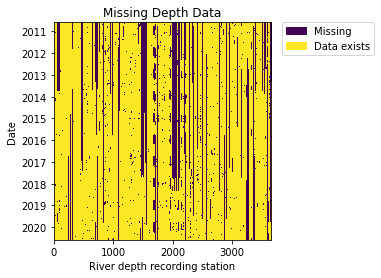

In [2]:
# --- Investigate how much data is missing from all the river stations
# --- Set threshold for % missing data to deem a station unusable (more than 10%)
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

dup_river_depth_df = river_depth_df.copy()
dup_river_depth_df = dup_river_depth_df.fillna(-1)
dup_river_depth_df[dup_river_depth_df != -1] = 1  # data exists = 1
dup_river_depth_df[dup_river_depth_df == -1] = 0  # missing data = 0

fig, ax = plt.subplots()
# https://stackoverflow.com/questions/23139595/dates-in-the-xaxis-for-a-matplotlib-plot-with-imshow
y1 = mdates.date2num(river_depth_df.index[0].to_pydatetime())
y0 = mdates.date2num(river_depth_df.index[-1].to_pydatetime())
im = ax.imshow(dup_river_depth_df.to_numpy(), interpolation='none', extent=[0, 3654, y0, y1])
ax.yaxis_date()

colors = [ im.cmap(im.norm(value)) for value in [0,1]]
patches = [ mpatches.Patch(color=colors[0], label="Missing"), mpatches.Patch(color=colors[1], label="Data exists")]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.ylabel('Date')
plt.xlabel('River depth recording station')
plt.title('Missing Depth Data')
plt.savefig('./presentation docs/missing_days_imshow.png', dpi=200)
plt.show()

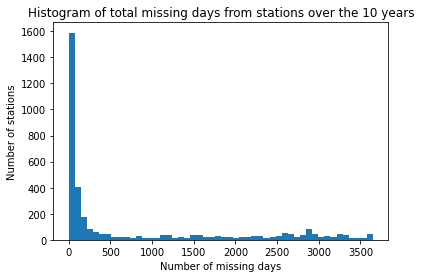

Number of river stations with perfect recording: 40
Number of river stations with 90% recordings: 2312


In [3]:
non_nas = river_depth_df.count()
max_days = 3654
plt.hist(max_days-non_nas, bins=50)
plt.ylabel('Number of stations')
plt.xlabel('Number of missing days')
plt.title('Histogram of total missing days from stations over the 10 years')
# https://stackoverflow.com/questions/50114882/using-savefig-to-increase-dots-per-inch-dpi-in-matplotlib-pyplot
plt.savefig('./presentation docs/missing_days.png', dpi=200)
plt.show()



print('Number of river stations with perfect recording:', sum(non_nas == max_days))
print('Number of river stations with 90% recordings:', sum(non_nas >= .9*max_days))


In [4]:
# --- Visualising location of these good rivers
good_rivers_bool = non_nas >= .9*max_days
good_river_sites = [river for good, river in zip(
    good_rivers_bool, list(river_depth_df)) if good]

# filter all recording sites to get only good river sites
# 1. get all sites + fix
df_raw_river_sites = pd.read_csv('input_data/recordingsites.tsv', sep='\t')
rec_sites_file = open('input_data/recordingsites.tsv')
lines = rec_sites_file.readlines()
df_raw_river_sites['site_no'] = [line.split('\t')[0] for line in lines[1:]]
rec_sites_file.close()
# 2. filter
filter_river_sites = [
    cand in good_river_sites for cand in df_raw_river_sites['site_no']]
df_raw_river_sites = df_raw_river_sites[filter_river_sites]

# Display on map
# https://plotly.com/python/scatter-plots-on-maps/
fig = px.scatter_geo(df_raw_river_sites,
                     lat='dec_lat_va',
                     lon='dec_long_va',
                     color="state_cd",  # which column to use to set the color of markers
                     hover_name="station_nm",  # column added to hover information
                     )
fig.show()


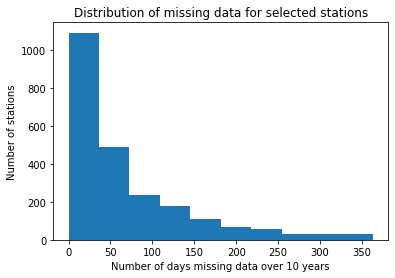

In [5]:
# --- Visualising quantity of missing data for selected stations
plt.hist(max_days-river_depth_df.loc[:, good_rivers_bool].count())
plt.ylabel('Number of stations')
plt.xlabel('Number of days missing data over 10 years')
plt.title('Distribution of missing data for selected stations')
plt.show()

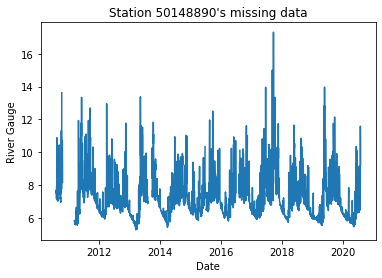

In [6]:
# --- Station 50148890 has 307 missing days - Where are they?
# Most missed days at the start
missing_days = max_days-river_depth_df.loc[:, good_rivers_bool].count()
# t
plt.plot(river_depth_df.index, river_depth_df['50148890'])
plt.ylabel('River Gauge')
plt.xlabel('Date')
plt.title('Station 50148890\'s missing data')
plt.savefig('./presentation docs/Station 50148890 depth.png', dpi=200)
plt.show()

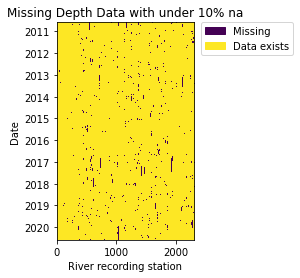

In [7]:
# --- Visualise missing data across all stations
dup_river_depth_df = river_depth_df.loc[:, good_rivers_bool].copy()
dup_river_depth_df = dup_river_depth_df.fillna(-1)
dup_river_depth_df[dup_river_depth_df != -1] = 1  # data exists = 1
dup_river_depth_df[dup_river_depth_df == -1] = 0  # missing data = 0
fig, ax = plt.subplots()
im = plt.imshow(dup_river_depth_df, interpolation='none', extent=[0, dup_river_depth_df.shape[1], y0, y1])
ax.yaxis_date()
plt.ylabel('Date')
plt.xlabel('River recording station')
plt.title('Missing Depth Data with under 10% na')
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.savefig('./presentation docs/missing_days_imshow2.png', dpi=200)
plt.show()

In [8]:
river_depth_df.loc[:, good_rivers_bool].shape

(3654, 2312)

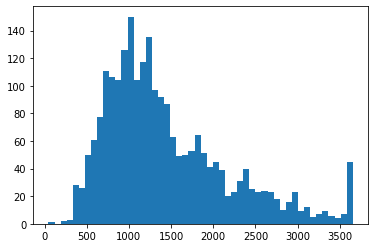

In [9]:
good_river_depth = river_depth_df.loc[:, good_rivers_bool].copy()
# return [first idx, last idx] of longest contiguous non-na
# https://stackoverflow.com/questions/41494444/pandas-find-longest-stretch-without-nan-values


def pir(x):
    # pad with np.nan
    x = np.append(np.nan, np.append(x, np.nan))
    # find where null
    w = np.where(np.isnan(x))[0]
    # diff to find length of stretch
    # argmax to find where largest stretch
    a = np.diff(w).argmax()
    # return original positions of boundary nulls
    return w[[a, a + 1]] + np.array([0, -2])


def length_contig(x):
    a, b = pir(x)
    return b-a+1


lengths_contig = good_river_depth.apply(length_contig)
plt.hist(lengths_contig, bins=50)
plt.show()

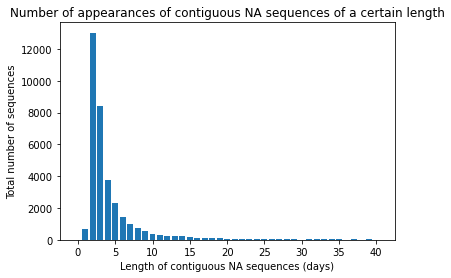

In [10]:
lengths = []
h_changes = []
riv_name = []
for riv in list(good_river_depth):
    x = good_river_depth[riv]
    w = np.where(np.isnan(x))[0]
    w_not = np.where(~np.isnan(x))[0]
    first_non_na, last_non_na = x[w_not[0]], x[w_not[-1]]
    temp_l = 1
    start_h, end_h = first_non_na, first_non_na
    for idx, loc in enumerate(w):
        if temp_l == 1 and loc != 0:
            start_h = x[loc-1]
        if idx == len(w)-1 or w[idx+1] != loc+1:
            lengths.append(temp_l)
            temp_l = 1
            end_h = x[loc+1] if loc != len(x)-1 else last_non_na
            h_changes.append(end_h-start_h)
            riv_name.append(riv)
        temp_l += 1
bars = 41
num_lengths = [lengths.count(idx) for idx in range(bars)]
plt.bar(x=range(bars),height=num_lengths)
plt.xlabel('Length of contiguous NA sequences (days)')
plt.ylabel('Total number of sequences')
plt.title('Number of appearances of contiguous NA sequences of a certain length')
plt.savefig('./presentation docs/missing_contig_sequence.png', dpi=200)
plt.show()

In [11]:
px.scatter(x=lengths, y=np.absolute(h_changes), hover_name=riv_name)

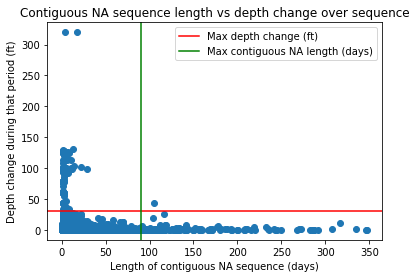

In [12]:
plt.scatter(lengths, np.absolute(h_changes))
plt.xlabel('Length of contiguous NA sequence (days)')
plt.ylabel('Depth change during that period (ft)')

# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-on-a-given-plot
# https://stackoverflow.com/questions/31950456/python-axhline-label-not-showing-up-in-plot
contiguous_max, ft_change_max = 90, 30

plt.axhline(ft_change_max, color='r', label="Max depth change (ft)")
plt.axvline(contiguous_max, color='g', label='Max contiguous NA length (days)')
plt.legend()
plt.title('Contiguous NA sequence length vs depth change over sequence')
plt.savefig('./presentation docs/contig_na_seq_vs_depth.png', dpi=200)
plt.show()

In [13]:
gaps_df = pd.DataFrame()
gaps_df['River'] = riv_name
gaps_df['Length_na'] = lengths
gaps_df['Ft_change'] = h_changes
gaps_df['Abs_ft_change'] = np.absolute(h_changes)
gaps_df['color'] = 'Resevoir/ Large gap'
filter_rivs = np.logical_and(
    gaps_df['Length_na'] < 90, gaps_df['Abs_ft_change'] < 30)
gaps_df.loc[filter_rivs, 'color'] = 'Fixable gap'
bad_rivs = gaps_df[gaps_df['color'] == 'Resevoir/ Large gap']['River'].unique()

print(f'Filter captures {100*sum(filter_rivs)/len(filter_rivs):.2f}% of gaps')
print(
    f'Number of rivers to remove - {len(bad_rivs)} of {len(list(good_river_depth))}')

Filter captures 99.23% of gaps
Number of rivers to remove - 161 of 2312


In [14]:
great_rivs = set(good_river_depth) - set(bad_rivs)

In [15]:
river_depth_df.loc[:, great_rivs]

,02327355,07374581,02391840,05051500,08170500,07144780,01389005,05526000,14144800,02298527,...,05536118,07143672,08019000,07059450,08136500,12108500,08098290,08033500,06824000,06796500
2010-08-01,1.68,0.62,1.83,5.65,4.95,6.93,2.275,3.17,8.80,43.05,...,-1.76,6.06,2.74,7.28,12.68,NaN,3.04,3.58,0.87,4.37
2010-08-02,1.68,0.78,1.84,5.66,4.94,6.91,2.295,3.06,8.79,43.70,...,-2.34,6.04,2.76,7.26,12.67,NaN,3.02,3.45,0.88,4.48
2010-08-03,1.68,0.76,1.83,5.84,4.93,6.89,2.270,3.11,8.79,43.81,...,-2.44,5.97,2.80,7.25,12.65,NaN,3.12,3.39,1.34,4.45
2010-08-04,1.66,0.76,1.83,6.04,NaN,6.88,2.230,3.17,8.78,44.21,...,-2.35,5.96,2.78,7.23,12.64,NaN,2.91,3.36,1.45,4.24
2010-08-05,1.84,0.84,1.85,6.06,NaN,6.87,2.200,3.15,8.77,44.46,...,-2.41,5.94,2.76,7.26,12.64,NaN,2.92,3.33,1.47,4.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-28,2.38,2.40,0.83,7.75,4.76,6.05,3.735,3.42,8.33,43.72,...,-1.91,6.18,2.63,6.51,12.70,1.07,1.98,4.65,1.59,4.10
2020-07-29,2.51,1.82,0.83,7.44,4.78,6.07,3.620,3.33,8.33,43.76,...,-2.04,6.18,2.61,6.56,12.70,1.07,1.92,4.81,1.86,4.20
2020-07-30,2.57,1.48,0.84,7.20,4.78,6.12,3.525,3.26,8.32,43.81,...,-2.21,6.21,2.65,6.55,12.68,1.07,2.12,4.80,1.52,4.41
2020-07-31,2.58,1.21,0.84,7.03,4.79,6.07,3.620,3.21,8.31,43.78,...,-2.17,6.19,2.77,6.53,12.69,NaN,1.94,4.43,1.91,4.25


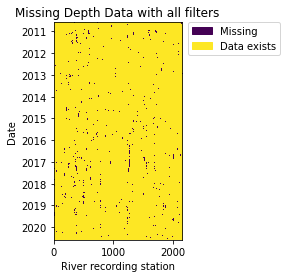

In [16]:
# --- Visualise missing data across all stations
dup_river_depth_df = river_depth_df.loc[:, great_rivs].copy()
dup_river_depth_df = dup_river_depth_df.fillna(-1)
dup_river_depth_df[dup_river_depth_df != -1] = 1  # data exists = 1
dup_river_depth_df[dup_river_depth_df == -1] = 0  # missing data = 0

fig, ax = plt.subplots()
plt.imshow(dup_river_depth_df, interpolation='none', extent=[0, dup_river_depth_df.shape[1], y0, y1])
ax.yaxis_date()
plt.ylabel('Date')
plt.xlabel('River recording station')
plt.title('Missing Depth Data with all filters')
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.savefig('./presentation docs/missing_days_imshow3.png', dpi=200)
plt.show()

In [17]:
great_depth_rivs = []
with open('eda_results/great_depth_rivs.txt', 'r') as in_file:
    great_depth_rivs = in_file.readline()[:-1].split(', ')
any_missed_rivs = len(great_depth_rivs) - len(set(great_rivs) & set(great_depth_rivs))
a,b = (' ',' not ')[any_missed_rivs==0], (any_missed_rivs, 'any')[any_missed_rivs==0]
print(f'Did{a}miss {b} great rivers compared to current file')

# with open('eda_results/great_depth_rivs.txt', 'w') as out:
#     print(', '.join(great_rivs), file=out)

# perfect_rivs_filter = good_river_depth.count() == max_days
# perfect_rivs = list(good_river_depth.loc[:, perfect_rivs_filter])

# with open('eda_results/perfect_depth_rivs.txt', 'w') as out:
#     print(', '.join(perfect_rivs), file=out)

Did not miss any great rivers compared to current file
